In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import umap
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from nltk.util import ngrams
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from itertools import combinations
from sklearn.metrics.pairwise import cosine_distances

In [438]:
def plot_dendrogram(linkage_matrix, threshold=None, **kwargs):
    """
    Plots a dendrogram based on hierarchical clustering results.

    Parameters:
    - linkage_matrix: Array-like, hierarchical clustering linkage matrix.
    - threshold: Float, optional. The threshold to draw across the dendrogram to denote specific clusters.
    - **kwargs: Other keyword arguments for the `dendrogram` function.

    Displays:
    - A dendrogram plot.
    """
    # Draw the dendrogram based on the linkage matrix.
    dendrogram(linkage_matrix, **kwargs)

    # Add a horizontal line (cutoff) if threshold value is provided.
    if threshold:
        plt.axhline(y=threshold, color='r', linestyle='--')

    # Labeling the dendrogram.
    plt.xlabel('Sample index')
    plt.ylabel('Distance')
    plt.title('Hierarchical Clustering Dendrogram')

    # Display the plot.
    plt.show()

def jaccard_similarity(list1, list2):
    """
    Calculate the Jaccard similarity between two lists.

    Parameters:
    - list1: List, first list of elements.
    - list2: List, second list of elements.

    Returns:
    - Float, Jaccard similarity coefficient.
    """
    intersection = len(set(list1).intersection(list2))
    union = len(set(list1).union(list2))
    return intersection / union if union else 0

def average_overlap_score(df, ngram_range, top_k):
    """
    Calculate the average Jaccard similarity across documents within the same cluster based on top k n-grams.

    Parameters:
    - df: DataFrame, contains 'label' and 'chunk' columns among others, where 'chunk' contains text data.
    - ngram_range: Tuple, specifies the range of n-value for the n-grams.
    - top_k: Int, the number of most common n-grams to consider.

    Returns:
    - Float, the average overlap score for the clusters.
    """
    scores = []

    # Iterate through each unique cluster label.
    for label in df['label'].unique():
        cluster_data = df[df['label'] == label]

        # Skip clusters with only one data point.
        if len(cluster_data) <= 1:
            continue

        # Extracting top k n-grams from each document in the cluster.
        top_ngrams_sets = []
        for chunk in cluster_data['chunk']:
            tokens = word_tokenize(chunk)
            all_ngrams = [gram for n in range(ngram_range[0], ngram_range[1]+1) for gram in ngrams(tokens, n)]
            freq_dist = FreqDist(all_ngrams)
            top_ngrams = {gram for gram, _ in freq_dist.most_common(top_k)}
            top_ngrams_sets.append(top_ngrams)

        # Calculate Jaccard similarities for each combination of documents in the cluster.
        for i, j in combinations(range(len(cluster_data)), 2):
            scores.append(jaccard_similarity(top_ngrams_sets[i], top_ngrams_sets[j]))

    # Return the average score.
    return sum(scores) / len(scores) if scores else 0

def cluster_dissimilarity_score(df):
    """
    Calculate the mean cosine distance between cluster centroids.

    Parameters:
    - df: DataFrame, contains 'label' columns and embedding vectors as additional columns.

    Returns:
    - Float, the average cosine distance between clusters.
    """
    # Exclude 'chunk' and 'label' columns to only keep the embedding columns.
    embedding_df = df.drop(columns=['chunk', 'label'])

    # Compute the mean embedding vector for each cluster.
    cluster_centroids = embedding_df.groupby(df['label']).mean().values

    # Compute pairwise cosine distances between cluster centroids.
    distances = cosine_distances(cluster_centroids)

    # Extract the upper triangular without the diagonal, as the matrix is symmetrical and we don't need the self-distances.
    scores = distances[np.triu_indices_from(distances, k=1)]

    # Return the mean of the distances.
    return scores.mean() if len(scores) else 0

def count_singletons(df, thresh=5):
    """
    Count the number of clusters that contain fewer samples than a specified threshold.

    Parameters:
    - df: DataFrame, contains 'label' and other columns.
    - thresh: Int, the maximum number of samples a "singleton" cluster may have.

    Returns:
    - Int, the number of singleton clusters.
    """
    singleton_count = 0
    for label in df['label'].unique():
        cluster_data = df[df['label'] == label]
        if len(cluster_data) < thresh:
            singleton_count += 1  # Counting each qualifying cluster.
    return singleton_count

def count_whales(df, thresh=0.1):
    """
    Count the number of "whale" clusters, i.e., clusters that contain a disproportionately large number of samples.

    Parameters:
    - df (DataFrame): A DataFrame where each row represents a sample and contains a 'label' column with cluster labels.
    - thresh (float): The threshold proportion of total samples for a cluster to be considered a 'whale'.

    Returns:
    - int: The number of samples in 'whale' clusters.
    """
    whale_count = 0 
    for label in df['label'].unique():
        cluster_data = df[df['label'] == label]
        if len(cluster_data)/len(df) > thresh:
            whale_count += len(cluster_data)
    return whale_count

def count_noise(df):
    """
    Calculate the proportion of samples that were not assigned any cluster label (considered as 'noise').

    Parameters:
    - df (DataFrame): A DataFrame where each row represents a sample and contains a 'label' column with cluster labels.

    Returns:
    - float: The proportion of noise samples.
    """
    noise = df['label'] == -1
    count = sum(noise)
    return count / len(df)

def objective_function(df, ngram_range=(1,2,3), top_k=10, desired_n_clusters=10):
    """
    Compute the objective function to evaluate the clustering. This function balances different metrics to assess the quality of the clustering.

    Parameters:
    - df (DataFrame): A DataFrame where each row represents a sample and contains a 'label' column with cluster labels.
    - ngram_range (tuple): The range of n-gram sizes to consider for calculating overlap score.
    - top_k (int): The number of top elements to consider for calculating overlap score.
    - desired_n_clusters (int): The number of desired clusters in the final labeling.

    Returns:
    - float: The computed objective score.
    """
    num_clusters = len(df['label'].unique())
    n = len(df)

    overlap = average_overlap_score(df, ngram_range, top_k)
    dissimilarity = cluster_dissimilarity_score(df)
    cluster_penalty = num_clusters / desired_n_clusters
    singleton_penalty = count_singletons(df) / n
    whale_penalty = count_whales(df) / n
    
    # The objective function aims to maximize the overlap and dissimilarity scores, while penalizing configurations that result in too many clusters, singleton clusters, or 'whale' clusters.
    return -(overlap + dissimilarity) / (cluster_penalty + singleton_penalty + whale_penalty)

def cosine_distance(u, v):
    """
    Calculate the cosine distance between two vectors.

    Parameters:
    - u, v (array-like): Input vectors.

    Returns:
    - float: Cosine distance between u and v.
    """
    # Calculate cosine similarity
    cosine_similarity = np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    # Cosine distance is defined as 1.0 minus the cosine similarity
    distance = 1.0 - cosine_similarity
    return distance
    
def get_clusters_from_threshold(linkage_matrix, threshold):
    """
    Retrieve cluster labels based on a specified distance threshold.

    Parameters:
    - linkage_matrix (numpy array): The hierarchical clustering linkage matrix.
    - threshold (float): The cutoff for the distance to form flat clusters.

    Returns:
    - array: An array of cluster labels.
    """
    # 'fcluster' forms flat clusters from the hierarchical clustering defined by the linkage matrix.
    return fcluster(linkage_matrix, threshold, criterion='distance')

def umap_reduction(data, n_neighbors=15, min_dist=0.1):
    """
    Perform dimensionality reduction on the data using UMAP (Uniform Manifold Approximation and Projection).

    Parameters:
    - data (DataFrame or numpy array): The input data for dimensionality reduction.
    - n_neighbors (int): The size of the local neighborhood used for manifold approximation. Larger values mean more global structure is preserved.
    - min_dist (float): The minimum distance between points in the low-dimensional space. Smaller values result in denser clustering, potentially capturing more detail.

    Returns:
    - array: The low-dimensional representation of the data.
    """
    # Initialize the UMAP reducer with the parameters
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist)
    # Fit the reducer to the data and perform the dimensionality reduction
    reduced_data = reducer.fit_transform(data)
    
    return reduced_data


In [281]:
# Import data where each column is one dimension of the chunk's embedding, and there is one column called 'chunk' which containst the original text for the embedding
chunk_df = pd.read_csv("./vectors.csv", index_col=0)
chunk_df = chunk_df[~chunk_df['chunk'].isna()]

# Isolate the vectors and normalize them
vectors = np.asarray(chunk_df.drop(columns=['chunk']))
norms = np.linalg.norm(vectors, axis=1, keepdims=True)

# To avoid division by zero, add a small constant where norms are zero.
norms[norms == 0] = 1e-10

vectors = vectors / norms

# Optional umap dimension reduction
# vectors = umap_reduction(vectors, n_neighbors=50, min_dist=0.2)

m = pairwise_distances(vectors, vectors, metric=cosine_distance)
m = np.clip(m, 0, 2)  # Ensuring that all distances are between 0 and 2

# Convert the squareform matrix to condensed form
condensed_m = m[np.triu_indices(m.shape[0], 1)]

In [450]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Define the objective function for Hyperopt
def objective(params):
  
    linkage_method = params['linkage_method']
    linkage_matrix = linkage(condensed_m, method=linkage_method)

    # Adding labels to the chunk dataframe
    chunk_df['label'] = fcluster(linkage_matrix, t=params['threshold'], criterion=params['cluster_criterion'])

    # Calculate the score using the objective function we defined earlier
    score = objective_function(chunk_df)

    return {'loss': score, 'status': STATUS_OK}

# n_neighbors_choices = list(range(5, 51)) # integers from 5 to 50
linkage_choices = ['average', 'weighted']
cluster_criterion_choices = ['distance']

# Define the parameter space that hyperopt will search over
space = {
    'linkage_method': hp.choice('linkage_method', linkage_choices),
    'cluster_criterion': hp.choice('cluster_criterion', cluster_criterion_choices), 
    'threshold': hp.uniform('threshold', 0.05, 0.3), 
    # 'min_dist': hp.uniform('min_dist', 0.01, 0.5),
    # 'n_neighbors': hp.choice('n_neighbors', n_neighbors_choices),  
}

In [451]:
# initialize a Trials object to store the hyperopt searches
trials = Trials()

In [452]:
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=1000, trials=trials)

100%|██████████| 100/100 [00:39<00:00,  2.51trial/s, best loss: -0.18414662313830077]


In [453]:
# Sort trials by loss, but provide a large default value for missing loss values
best_trial = sorted(trials.trials, key=lambda x: x.get('loss', float('inf')))[0]
best_params_indices = best_trial['misc']['vals']

# Convert indices to actual parameters based on the space definition
best_params = {}

for k, v in best_params_indices.items():
    if k == 'linkage_method':
        best_params[k] = linkage_choices[v[0]]
    elif k == 'cluster_criterion':
        best_params[k] = cluster_criterion_choices[v[0]]
    # elif k == 'n_neighbors': 
    #     best_params[k] = n_neighbors_choices[v[0]]
    else:
        best_params[k] = v[0]

print(best_params)

{'cluster_criterion': 'distance', 'linkage_method': 'weighted', 'threshold': 0.21170069175182543}


In [454]:
# Use the hyperparameter configuration with the best optimization score to label the data
best_linkage_matrix = linkage(condensed_m, method=best_params['linkage_method'])
t = best_params['threshold']
best_results = fcluster(best_linkage_matrix, t=t, criterion=best_params['cluster_criterion'])

view = 25 # number of labels to view in the cumulative sum

chunk_df['label'] = best_results
print(f"There are {len(chunk_df.label.unique().tolist())} labels for {len(chunk_df)} chunks ({(len(chunk_df)/len(chunk_df.label.unique().tolist())):.2f})")
print(chunk_df.label.value_counts(normalize=True).cumsum()[:view])
chunk_df.label.value_counts()[:view]

There are 155 labels for 1003 chunks (6.47)
label
134    0.071785
24     0.121635
119    0.163509
90     0.205384
56     0.237288
54     0.267198
52     0.287139
25     0.306082
58     0.325025
72     0.342971
87     0.360917
50     0.377866
85     0.394816
68     0.411765
75     0.428714
46     0.442672
95     0.455633
62     0.467597
42     0.478564
109    0.489531
105    0.500499
102    0.511466
104    0.521436
53     0.531406
77     0.541376
Name: proportion, dtype: float64


label
134    72
24     50
119    42
90     42
56     32
54     30
52     20
25     19
58     19
72     18
87     18
50     17
85     17
68     17
75     17
46     14
95     13
62     12
42     11
109    11
105    11
102    11
104    10
53     10
77     10
Name: count, dtype: int64

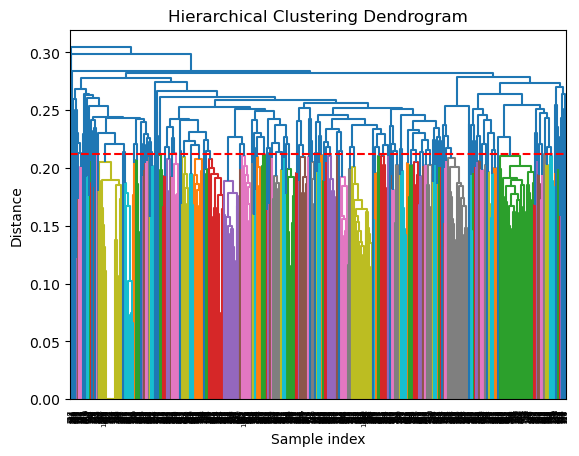

In [456]:
plot_dendrogram(best_linkage_matrix, threshold=t)